In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import *

# ------------------------------------------
### data visualization and downstream analysis


In [4]:
data_temp_path = os.path.abspath('./../../../temp_data_path_EB')

img_outs = os.path.join(data_temp_path, 'IMG')
pathway_dir = os.path.join(data_temp_path, 'pathways')

In [5]:
# load pre-run data

res= pd.read_csv(os.path.join(data_temp_path, 'mwcq_res_all.csv'), index_col = 0)
p_res= pd.read_csv(os.path.join(data_temp_path, 'mwcq_res_aggregated.csv'), index_col = 0)

/Users/hollysteach/anaconda3/envs/met_env_sc/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


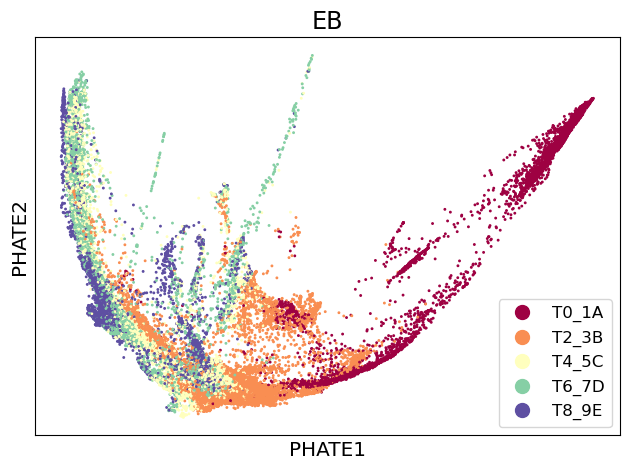

In [6]:
with open(os.path.join(data_temp_path, 'adata_prepross_all.pk'), 'rb') as handle:
    adata = pk.load(handle)

import scprep
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['sample_labels'], title='EB', cmap= 'Spectral',
                      ticks=False, label_prefix='PHATE')
plt.show()

In [7]:
import scprep

with open(os.path.join(data_temp_path, 'data_magic.pk'), 'rb') as handle:
    data_magic = pk.load(handle)

adata.var_names_make_unique()
dg = [g.split(" (")[0] for g in adata.var_names]

data = pd.DataFrame(data_magic, index = adata.obs_names, columns =  dg)

####
adata.var_names = dg

#delta gene exp
data_all = data.copy()
t0 = [str(index).__contains__('1A') for index in data.index]
ctrl = data[t0].mean()
data = data - ctrl
data.drop(data_all[t0].index, inplace=True)

#subset to neuronal
tL =[str(index).__contains__('T8') for index in data.index]
df = data[tL]
data = df





In [8]:
adata.X = data_magic

#neuronal mask
data = data[data['ONECUT2'] > 0.2]

#save in adata
#adata[(adata.obs['sample_labels'] == 'T8_9E') & (adata.obs_vector('ONECUT2') > 0.2)]
adata.obs['neuronal'] = [1 if i in data.index else 0 for i in adata.obs_names]

adata.X = data_magic

/Users/hollysteach/anaconda3/envs/met_env_sc/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


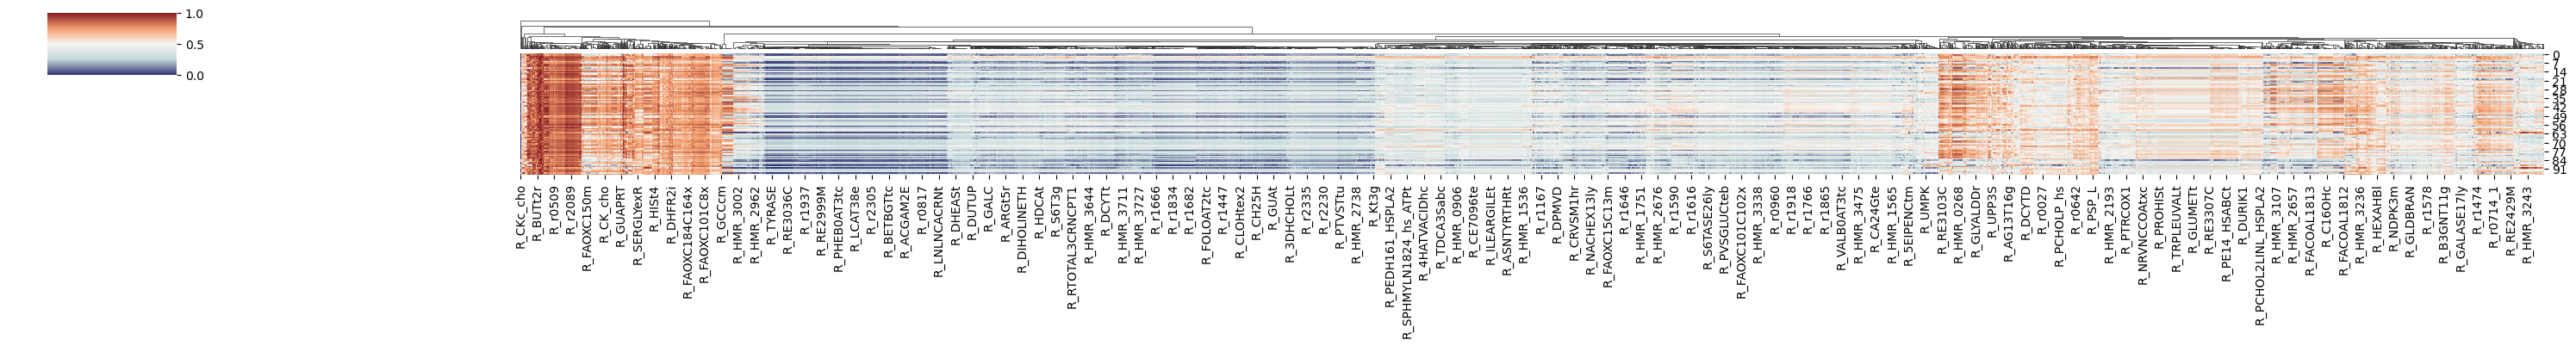

In [9]:
df = res

import matplotlib.colors as clr
from matplotlib.colors import LinearSegmentedColormap

colors = ['#861A22', '#F29E6D', '#F6F4F1', '#C3D8DB', '#353273']
colors = ['#353273', '#C3D8DB', '#F6F4F1', '#F29E6D', '#861A22']
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)
custom_cmap

sns.clustermap(df, figsize=(30, 4), standard_scale=0.5,
               row_cluster=False, cmap=custom_cmap)

plt.savefig(os.path.join(img_outs, 'mwc_p_heatmap.pdf'))
plt.show()

In [10]:
'''
- load curated pathway lists 
#https://github.com/SysBioChalmers/Human-GEM/blob/main/model/reactions.tsv
- modify labels to be consistent
- save dictionary of pathway support values
'''


# print(os.listdir(pathway_dir))
r_name_conv = pd.read_csv(os.path.join(pathway_dir, 'naming_conventions.tsv'), sep='\t')
rnc = r_name_conv.loc[:, ['rxns', 'rxnRecon3DID']].dropna(subset=['rxnRecon3DID'])


pathway_master = '/Users/hollysteach/Documents/project_krishnaswamy/0_metabolism/pathway_lists/pathway_master.csv'
pm = pd.read_csv(os.path.abspath(pathway_master))
pm = pm.iloc[:,:10]

In [11]:
pathways = {}

for i, pw in enumerate(pm.columns):
    # print(pw)
    from_master = pm.loc[:,pw]
    # from_master.columns = ['pathway_reactions']
    path_merged = pd.merge(from_master, rnc, how= 'left', left_on= pw, right_on = 'rxns').dropna()
    # print(t.shape)
    r_ID = np.unique([f'R_{r}' for r in path_merged['rxnRecon3DID']])
    r_ID = [r for r in r_ID if r in p_res.index]
    support_vals = np.array(p_res.loc[r_ID, 'support'])

    
    
    pathways[pw] = pd.DataFrame({'reaction_ID': r_ID, 'support': support_vals})

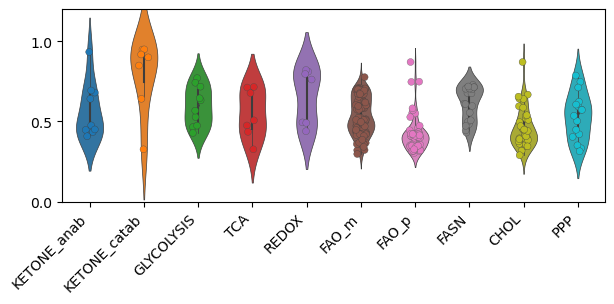

In [12]:
path_comb = pd.DataFrame({key: pd.Series(value['support']) for key, value in pathways.items()})
sns.reset_defaults()

fig, ax = plt.subplots(1,1, figsize = (7,2.5))
sns.violinplot(data=path_comb, inner="box", linewidth= 0.5, size=16, scale="width", width=0.5,
               ax = ax)

sns.stripplot(data=path_comb, jitter=True, s= 5, ax=ax, linewidth=0.25)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim(0,1.2)
ax.set_yticks([0, 0.5, 1])

plt.savefig(os.path.join(img_outs, 'pathway_violin.pdf'), dpi= 300)
plt.show()

In [13]:
sub_paths = ['KETONE_catab', 'TCA', 'REDOX']
heatmap_path = os.path.join(img_outs, 'path_sub_heatmap.pdf')

In [14]:
pathways['KETONE_catab']['reaction_ID'].tolist()

['R_2HBt2',
 'R_ACETONEt2',
 'R_ACETONEt2m',
 'R_BDHm',
 'R_BUTt2m',
 'R_BUTt2r',
 'R_OCOAT1m']

In [15]:
pathways['TCA']['reaction_ID'].tolist()

['R_CSm',
 'R_FUMm',
 'R_ICDHxm',
 'R_MDHm',
 'R_OCOAT1m',
 'R_SUCOAS1m',
 'R_SUCOASm']

In [16]:
TCA_manual = ['R_ACONTm',
'R_ICDHxm',
'R_ICDHyrm',
'R_AKGDm',
'R_OCOAT1m',
'R_SUCOAS1m',
'R_SUCOASm',
'R_SUCD1m',
'R_r0509',
'R_FUMm',
'R_MDHm',
'R_CSm']

TCA_manual = [r for r in TCA_manual if r in res.columns]


ketone_manual = ['R_2HBt2',
'R_BUTt2r',
'R_BUTt2m',
'R_ACETONEt2',
'R_ACETONEt2m',
'R_BDHm',
'R_OCOAT1m',
'R_ACACT1m']

ketone_manual = [r for r in ketone_manual if r in res.columns]

In [17]:
#manual

t = []
t_labs = []

#ketone
p = 'KETONE_catab'
p_sub = ketone_manual
t += p_sub
for ps in p_sub:
    t_labs += [[p, ps]]
#tca
p = 'TCA'
p_sub = TCA_manual
t += p_sub
for ps in p_sub:
    t_labs += [[p, ps]]
#redox
p = 'REDOX'
p_sub = pathways['REDOX']['reaction_ID'].tolist()
t += p_sub
for ps in p_sub:
    t_labs += [[p, ps]]

In [18]:
res_sub = res.loc[:,t]
sub_labs = pd.DataFrame(t_labs, columns = ['pathway', 'reactions'])

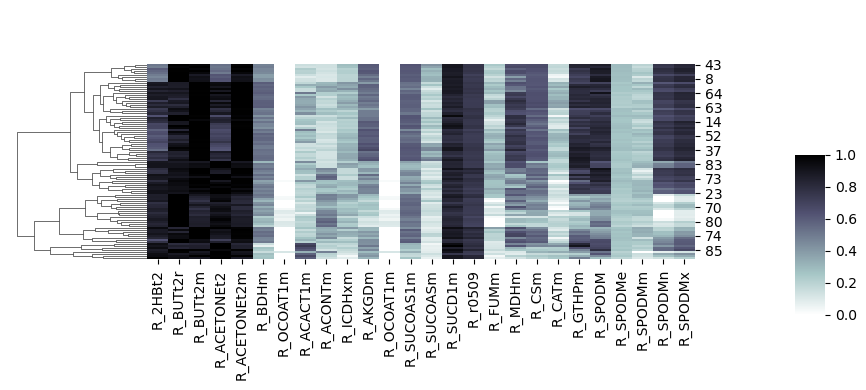

In [19]:
df = res_sub
g = sns.clustermap(df, figsize=(10, 4), standard_scale=0.5,
               row_cluster=True, col_cluster = False, cmap='bone_r')
row_order = g.dendrogram_row.reordered_ind

g.fig.subplots_adjust(right=0.7)
g.ax_cbar.set_position((0.8, .2, .03, .4))

plt.savefig(heatmap_path)
plt.show()

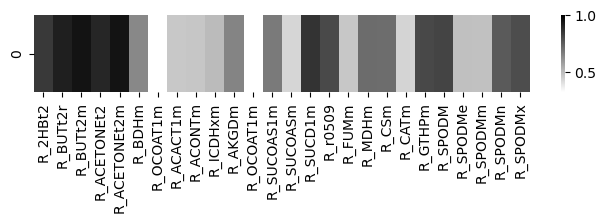

In [20]:
plt.figure(figsize=(8, 1))
t = pd.DataFrame(np.median(res_sub, axis = 0))
t.index = res_sub.columns
sns.heatmap(t.T, cmap= 'gray_r', vmax = 1)

fname = os.path.join(img_outs, 'node_colors_illustration.pdf')
plt.savefig(fname, dpi= 300)

plt.show()

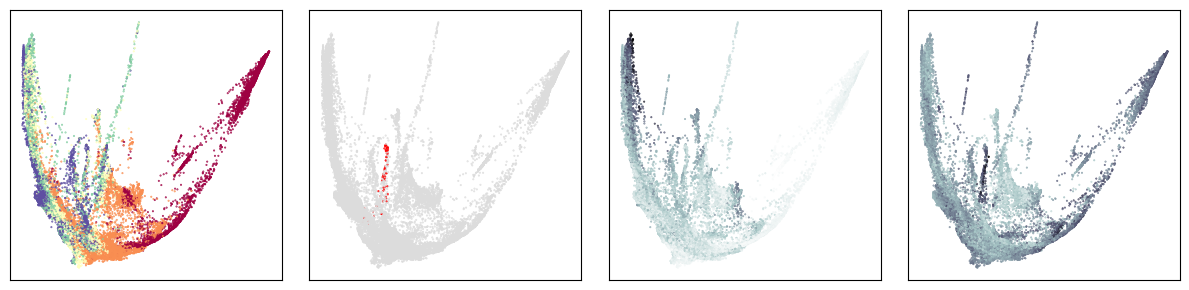

In [21]:
fig, axes = plt.subplots(1, 4, figsize = (12,3))
s_size = 0.2
fontsize = 14

# ax = axes.flatten()[0]
ax = axes[0]
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['sample_labels'], title=None, cmap= 'Spectral', s= s_size, legend = False, fontsize= fontsize,
                      ticks=False, label_prefix=None, ax = ax)

# ax = axes.flatten()[1]
ax = axes[1]
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['neuronal'], title=None, cmap= ['gainsboro', 'red'], s= s_size, legend = False,fontsize= fontsize,
                      ticks=False, label_prefix=None, ax = ax)

ax = axes[2]
g = 'SLC16A3'
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs_vector(g), title=None, cmap= 'bone_r', s= s_size, legend = False, vmin=0,fontsize= fontsize,
                      ticks=False, label_prefix=None, ax = ax)

ax = axes[3]
g = 'ACAT1'
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs_vector(g), title=None, cmap= 'bone_r', s= s_size, legend = False, vmin=0,fontsize= fontsize,
                      ticks=False, label_prefix=None, ax = ax)


fig.tight_layout(w_pad=2)
plt.savefig(os.path.join(img_outs, 'EB_phate_neuronal.png'), dpi = 300)
plt.show()

In [22]:
adata_n =adata[adata.obs['neuronal'] == 1]

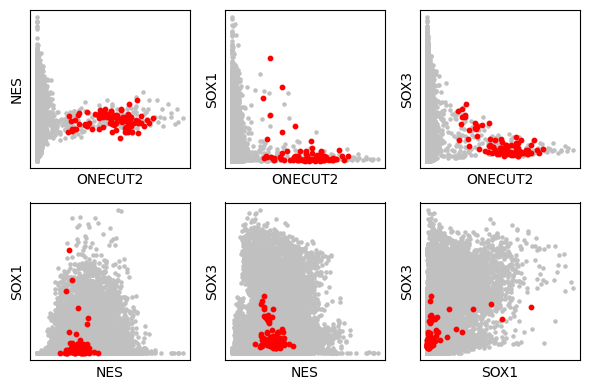

In [23]:
genelist = [['ONECUT2','NES'],
            ['ONECUT2','SOX1'],
            ['ONECUT2','SOX3'],
            ['NES','SOX1'],
            ['NES','SOX3'],
            ['SOX1','SOX3']]

fig, axes = plt.subplots(2, 3, figsize = (6,4))
for i, ax in enumerate(axes.flatten()):
    gx = genelist[i][0]
    gy = genelist[i][1]
    ax.scatter(x = adata.obs_vector(gx), y = adata.obs_vector(gy), s= 5, c= 'silver')
    ax.scatter(x = adata_n.obs_vector(gx), y = adata_n.obs_vector(gy), s= 10, c= 'red')
    ax.set_xlabel(gx)
    ax.set_ylabel(gy)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

In [24]:

gene_x = 'ONECUT2'
fname = 'ONECUT2_drevi.pdf'

# gene_x = 'NES'
# fname = 'NESTIN_drevi.pdf'


genelist = ['SLC16A1',
             'SLC16A7',
             'SLC16A3',
             'BDH1',
             'BDH2',
             'OXCT1',
             'OXCT2',
             'ACAT1',
            'ACO1', 'ACO2',
            'IDH1', 'IDH2',
            'FH',
            'SDHA', 'SDHB', 'SDHC', 'SDHD',
            'MDH2', 
            'CS']



dremi_vals = []
drevi = []

for g in genelist:
    gene_x = gene_x
    gene_y = g

    x = adata.obs_vector(gene_x)
    y = adata.obs_vector(gene_y)


    n_bins = 40

    d = scprep.stats.knnDREMI(x, y, n_bins = n_bins,
                      xlabel=gene_x, ylabel=gene_y, plot=False, return_drevi = True)
    
    dremi_vals += [d[0]]
    drevi += [d[1]]

/Users/hollysteach/anaconda3/envs/met_env_sc/lib/python3.11/site-packages/scprep/stats.py:261: RuntimeWarning: divide by zero encountered in divide
  density = k / area
/Users/hollysteach/anaconda3/envs/met_env_sc/lib/python3.11/site-packages/scprep/stats.py:261: RuntimeWarning: divide by zero encountered in divide
  density = k / area
/Users/hollysteach/anaconda3/envs/met_env_sc/lib/python3.11/site-packages/scprep/stats.py:261: RuntimeWarning: divide by zero encountered in divide
  density = k / area


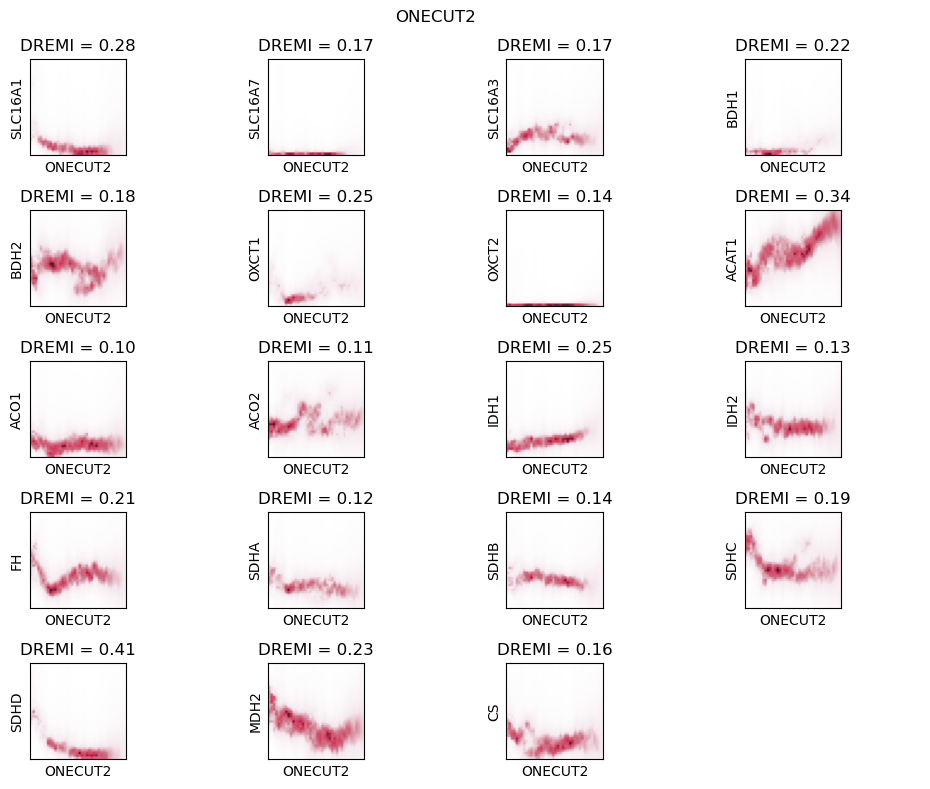

In [25]:
colors = ['#FFFFFF', '#F4E7ED', '#CE7286', '#D63A5C', '#4C1B33']
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)
custom_cmap


fig, axes = plt.subplots(5,4, figsize = (10,8))
cmap = custom_cmap

for i, ax in enumerate(axes.flatten()):
    if i >= len(drevi):
        ax.set_axis_off()
    else:
        ax.imshow(drevi[i].reshape(n_bins,n_bins), origin='lower', cmap = cmap)
        ax.set_xticks([]); ax.set_yticks([]);
        ax.set_xlabel(gene_x)
        ax.set_ylabel(genelist[i])
        ax.set_title(f'DREMI = {str(dremi_vals[i])[:4]}')

plt.suptitle(gene_x)
fig.tight_layout()

plt.savefig(os.path.join(img_outs, fname))


plt.show()

In [26]:
gene_x = 'FOXD3'
fname = 'FOXD3_drevi.pdf'

# gene_x = 'NES'
# fname = 'NESTIN_drevi.pdf'


genelist = ['SLC16A1',
             'SLC16A7',
             'SLC16A3',
             'BDH1',
             'BDH2',
             'OXCT1',
             'OXCT2',
             'ACAT1',
            'ACO1', 'ACO2',
            'IDH1', 'IDH2',
            'FH',
            'SDHA', 'SDHB', 'SDHC', 'SDHD',
            'MDH2', 
            'CS']



dremi_vals = []
drevi = []

for g in genelist:
    gene_x = gene_x
    gene_y = g

    x = adata.obs_vector(gene_x)
    y = adata.obs_vector(gene_y)


    n_bins = 40

    d = scprep.stats.knnDREMI(x, y, n_bins = n_bins,
                      xlabel=gene_x, ylabel=gene_y, plot=False, return_drevi = True)
    
    dremi_vals += [d[0]]
    drevi += [d[1]]

/Users/hollysteach/anaconda3/envs/met_env_sc/lib/python3.11/site-packages/scprep/stats.py:261: RuntimeWarning: divide by zero encountered in divide
  density = k / area
/Users/hollysteach/anaconda3/envs/met_env_sc/lib/python3.11/site-packages/scprep/stats.py:261: RuntimeWarning: divide by zero encountered in divide
  density = k / area
/Users/hollysteach/anaconda3/envs/met_env_sc/lib/python3.11/site-packages/scprep/stats.py:261: RuntimeWarning: divide by zero encountered in divide
  density = k / area


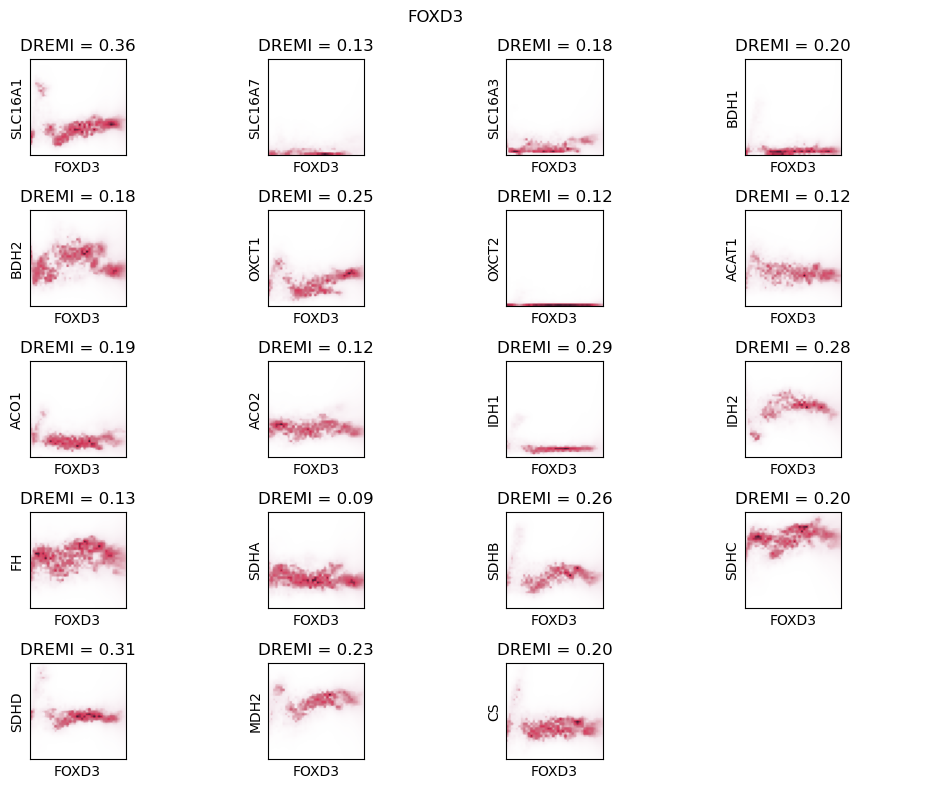

In [27]:
colors = ['#FFFFFF', '#F4E7ED', '#CE7286', '#D63A5C', '#4C1B33']
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)
custom_cmap


fig, axes = plt.subplots(5,4, figsize = (10,8))
cmap = custom_cmap

for i, ax in enumerate(axes.flatten()):
    if i >= len(drevi):
        ax.set_axis_off()
    else:
        ax.imshow(drevi[i].reshape(n_bins,n_bins), origin='lower', cmap = cmap)
        ax.set_xticks([]); ax.set_yticks([]);
        ax.set_xlabel(gene_x)
        ax.set_ylabel(genelist[i])
        ax.set_title(f'DREMI = {str(dremi_vals[i])[:4]}')

plt.suptitle(gene_x)
fig.tight_layout()

plt.savefig(os.path.join(img_outs, fname))


plt.show()